

## Melanoma Classification with Transfer Learning and Hyperparameter Tuning

### Project Overview

This project focuses on the classification of melanoma using dermoscopic images and deep learning techniques. The main objective is to improve the diagnostic performance of a pre-trained convolutional neural network model through **fine-tuning** and **hyperparameter optimization**.

We start with an EfficientNetB0 model pre-trained on ImageNet and perform transfer learning using a custom melanoma dataset. To enhance the model’s performance, we apply Keras Tuner to search for optimal training parameters such as dropout rate and learning rate.

### Dataset

The dataset is structured into three subsets:

* `train/`: Used for training the model.
* `validation/`: Used to tune and validate model performance during training.
* `test/`: Used for final model evaluation.

The dataset is balanced using class weights due to class imbalance (e.g., fewer malignant samples).

### Methodology

1. **Transfer Learning**: Load the EfficientNetB0 model with ImageNet weights.
2. **Data Preprocessing**: Images are resized to 224x224 and normalized using `preprocess_input`.
3. **Hyperparameter Tuning**:

   * Performed using `keras-tuner`.
   * Searched over a range of dropout rates and learning rates.




In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.utils.class_weight import compute_class_weight
!pip install keras-tuner
import keras_tuner as kt


if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
!cp -r "/content/drive/My Drive/melonoma_classification_dataset" "/content/dataset"

base_dir = "/content/dataset/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='binary'
)

# Sınıf ağırlıklarını hesapla
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 7477 images belonging to 2 classes.
Found 1342 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, optimizers, Model

def build_model(hp):
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base_model.trainable = True  # Fine-tune tamamı

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(hp.Float("dropout_rate", 0.2, 0.5, step=0.1))(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    hp_learning_rate = hp.Choice("lr", values=[1e-4, 1e-5, 5e-5])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



In [6]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="/content/drive/My Drive/tuning_resultss",
    project_name="melanoma_finetune"
)

tuner.search(
    train_generator,
    validation_data=val_generator,
    class_weight=class_weights,
    epochs=10
)


Trial 5 Complete [00h 03m 31s]
val_accuracy: 0.9500744938850403

Best val_accuracy So Far: 0.9508196711540222
Total elapsed time: 00h 18m 37s


As you can see, the validation accuracy reaches approximately 95%, which initially seems very promising. However, when the model is trained for the full 30 epochs without early stopping, the gap between training and validation accuracy starts to widen — a clear sign of overfitting.

This behavior indicates that the model is beginning to memorize the training data rather than generalizing well to unseen examples. So I enhanced epoch size, reduce learning rate and plot the accuracy graph.




In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Class weight (dengesiz veri için)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(2)}

# Model oluştur
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# İlk katmanları dondur
for layer in base_model.layers:
    layer.trainable = False

# Derle
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callback'ler
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("/content/drive/MyDrive/melonoma_classification_model/final_finetuned_model.keras",
                             save_best_only=True, monitor='val_loss', mode='min')

# Eğit
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)



Epoch 1/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.5210 - loss: 0.7185 - val_accuracy: 0.5492 - val_loss: 0.6726
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5882 - loss: 0.6682 - val_accuracy: 0.6781 - val_loss: 0.6230
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6473 - loss: 0.6260 - val_accuracy: 0.7541 - val_loss: 0.5850
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7052 - loss: 0.5931 - val_accuracy: 0.7802 - val_loss: 0.5546
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.7294 - loss: 0.5692 - val_accuracy: 0.7928 - val_loss: 0.5303
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7585 - loss: 0.5489 - val_accuracy: 0.8018 - val_loss: 0.5099
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7767 - loss: 0.5264 - val_accuracy: 0.8092 - val_loss: 0.4925
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7818 - loss: 0.5092 - val_a

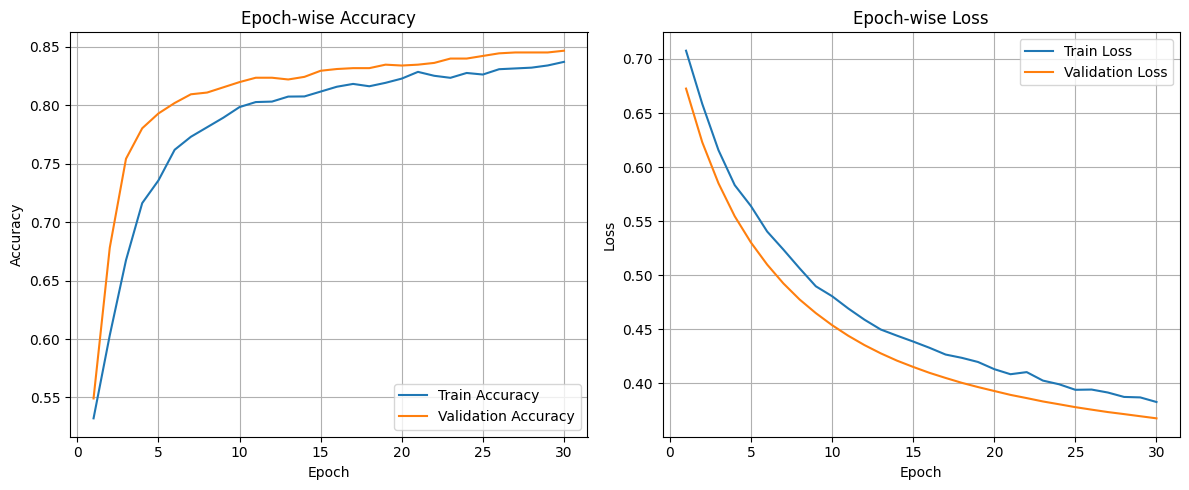

In [17]:
import matplotlib.pyplot as plt

# Getting the metrics.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Figure size setting
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch-wise Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch-wise Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [18]:
final_model_path = "/content/drive/MyDrive/melonoma_classification_model/final_finetuned_model.keras"
model.save(final_model_path)